# Milestone 2: Assembling training data, due Wednesday, April 12, 2017

### Group 11: Xu Si, Hungyi Wu, Chongfan Tai

We are aware that you have little time this week, due to the midterm. So this milestone is a bit easier to achieve than the others. The goal for this week is to prepare the data for the modeling phase of the project. **You should end up with a typical data setup of training data X and data labels Y.**

The exact form of X and Y depends on the ideas you had previously. In general though Y should involve the genre of a movie, and X the features you want to include to predict the genre. Remember from the lecture that more features does not necessarily equal better prediction performance. Use your application knowledge and the insight you gathered from your genre pair analysis and additional EDA to design Y. **Do you want to include all genres?** Are there genres that you assume to be easier to separate than others? Are there genres that could be grouped together? There is no one right answer here. We are looking for your insight, so be sure to describe your decision process in your notebook. 

In preparation for the deep learning part we strongly encourage you to have **two sets of training data X**, one with the metadata and one with the movie posters. Make sure to have a common key, like the movie ID, to be able to link the two sets together. Also be mindful of the data rate when you obtain the posters. Time your requests and choose which **poster resolution** you need. In most cases w500 should be sufficient, and probably a lower resolution will be fine.

The notebook to submit this week should at least include:

- Discussion about the imbalanced nature of the data and how you want to address it
- Description of your data
- What does your choice of Y look like?
- Which features do you choose for X and why? 
- How do you **sample your data, how many samples**, and why?

*Important*: You do not need to upload the data itself to Canvas.

In [45]:
import numpy as np
import pickle
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns
import ast
from collections import Counter
%matplotlib inline

## Look at our data!

In [28]:
with open("Final!.txt", "rb") as input_file:
     merged = pickle.load(input_file)

In [29]:
print data.shape
data.head(5)

(226888, 49)


,popularity,color info,revenue,editorial department_count,budget,production_companies_count,video,year,art department_count,id,...,release_date,transportation department_count,casting director_count,costume designer_count,genres_y,title_y_count,overview_count,vote_average,distributors_count,art direction_count
0,0.000576,['Black and White'],0,0,0,2,False,1939.0,0,188768,...,1939-11-25,0,0,1,"[u'Crime', u'Drama']",16,141,6.5,3,1
1,0.000343,['Black and White'],0,0,0,1,False,1940.0,0,218310,...,1940-12-20,0,0,1,[u'Drama'],15,509,0.0,4,0
2,0.000213,['Black and White'],0,0,0,1,False,1941.0,0,73155,...,1941-08-02,0,0,1,[u'Comedy'],32,542,0.0,0,0
3,0.001449,['Black and White'],0,0,0,1,False,1894.0,0,16612,...,1894-03-14,0,0,0,[u'Documentary'],10,294,5.1,2,0
4,0.000162,['Color::(hand painted)'],0,0,0,0,False,1892.0,0,16613,...,1892-10-27,0,0,0,[u'Animation'],22,46,0.0,0,0


In [40]:
data['merge_genres'] = data['merge_genres'].apply(ast.literal_eval)

### I. Discussion about the imbalanced nature of the data and how you want to address it 

No matter what genres encoding we choose, we will face the problem of class imbalance. To deal with this problem, we choose to:

1. We will consider stratified sampling to make sure the train set and test set have the same proportion movies of different genres. The same strategy applies to cross-validation.

2. We may also consider resampling and downsampling to make sure all the genres are balanced.

###  II. Description of your data 

We have downloaded all the data from IMDb and TMDb!

We use movie ID in IMDb to merge the desired information in the megadata from IMDb and TMDb: If the genre labels are different from IMDb and TMDb for a movie, we keep the joint labels (if no intersection is found, we remove the movie). If the genre labels are missing from one database, we use the genre tags from the other database directly. If both have null genre values, we remove the movie from our dataset.

**We end up with 226,888 movies!**

### III. What does your choice of Y look like? 

We decide to use three sets of Y:

1) **Binary class problem drama vs. non-drama**: Since there are so many drama moives in the whole dataset, we are interested in telling the differences between the drama movies and non-drama movies. If we see "drama" in the labels of a movie, we label it as drama and if not, we lable it as non-drama.

2) **Multi-class problem Top 20 genres/genres groups**: We show below the top 20 most frequent genres and/or groups of genres. We aggregate all other less frequent genres together and treat as “others”. We may include the “others” in the modeling depending on whether it can contribute to the classification accuracy. 

> *The reason we are doing this way is that, e.g. movie A is labeled as romance and movie B is labeled as drama and still we have another movie C labeled both romance and drama. We can not simply say movie C is either romance or drama because it shows both properties. What we do is to give three candidate genres: pure romance, pure drama and drama&romance which makes more sense in the movie classification case. Now, if a fourth movie comes with label "drama, romance, history and war", we again treat it as a new label "drama, romance, history and war" instead of assigning it to one of the "romance", "history","war" and "drama". Done!*

>**Why top 20s**? We can not consider all the labels that we see in our dataset. For example, we may see a movie labels as "romance, drama, documentary" and another labeled as "drama, music, horror, war", and we shall have **5221** different labels!! OMG! So we decide to choose the most representative genre labels to treat all the rest as "others."

>*Also, it is really hard to come up with a good way to aggregate the genres. For example, if we combine "romance" and "drama" as one group, and we decide to label a movie of "romance, drama" this way, it should be fine. Then if we have another movie of "romance, drama, war", then we are in trouble labeling this movie. Does it belong to "romance & drama" or to "war"? We will encounter this problem millions of times!*

>*We have also thought this way: for a movie of "romance, drama", we transform this movie into two movies of different genres but the same features. In other words, we duplicate the movie twice with one single label each. But, it may confuse the classifier! The same information is given to two classes! Not good! So end up getting rid of this idea.* 

3) **Multi-label problem: ** We will also consider **multilabel problem**. It accords with our original dataset and we are not losing any information! Great. 

Okay, so, we all agree on the three reasonable labeling methods, the next step is to select and tranform the x feautures as we shall explain below!

**Yet another idea**: we can split all the movies into before 1960s and after 1960s and train two models, because the budgets and revenue may change over time, also attributes of movies involve over time.

**All the genres**

In [46]:
genre_collapse_list = []
for e in data['merge_genres'].values:
    genre_collapse_list += e
genre_category_list = dict(Counter(genre_collapse_list)).keys()

In [48]:
#all the genres we have 
np.reshape(genre_category_list,newshape= (1,-1))

array([[u'Mystery', u'Short', u'Sci-Fi', u'Talk-Show', u'Crime',
        u'Romance', u'Animation', u'Music', u'Foreign', u'Action',
        u'TV Movie', u'Game-Show', u'Comedy', u'Documentary', u'War',
        u'History', u'Drama', u'Biography', u'Family', u'Fantasy',
        u'Horror', u'Film-Noir', u'Musical', u'Science Fiction',
        u'Western', u'Adult', u'News', u'Sport', u'Reality-TV',
        u'Thriller', u'Adventure']], 
      dtype='<U15')

**All unique labels**

In [49]:
len(data['merge_genres'].value_counts())

5221

**Top genre labels of a movie**

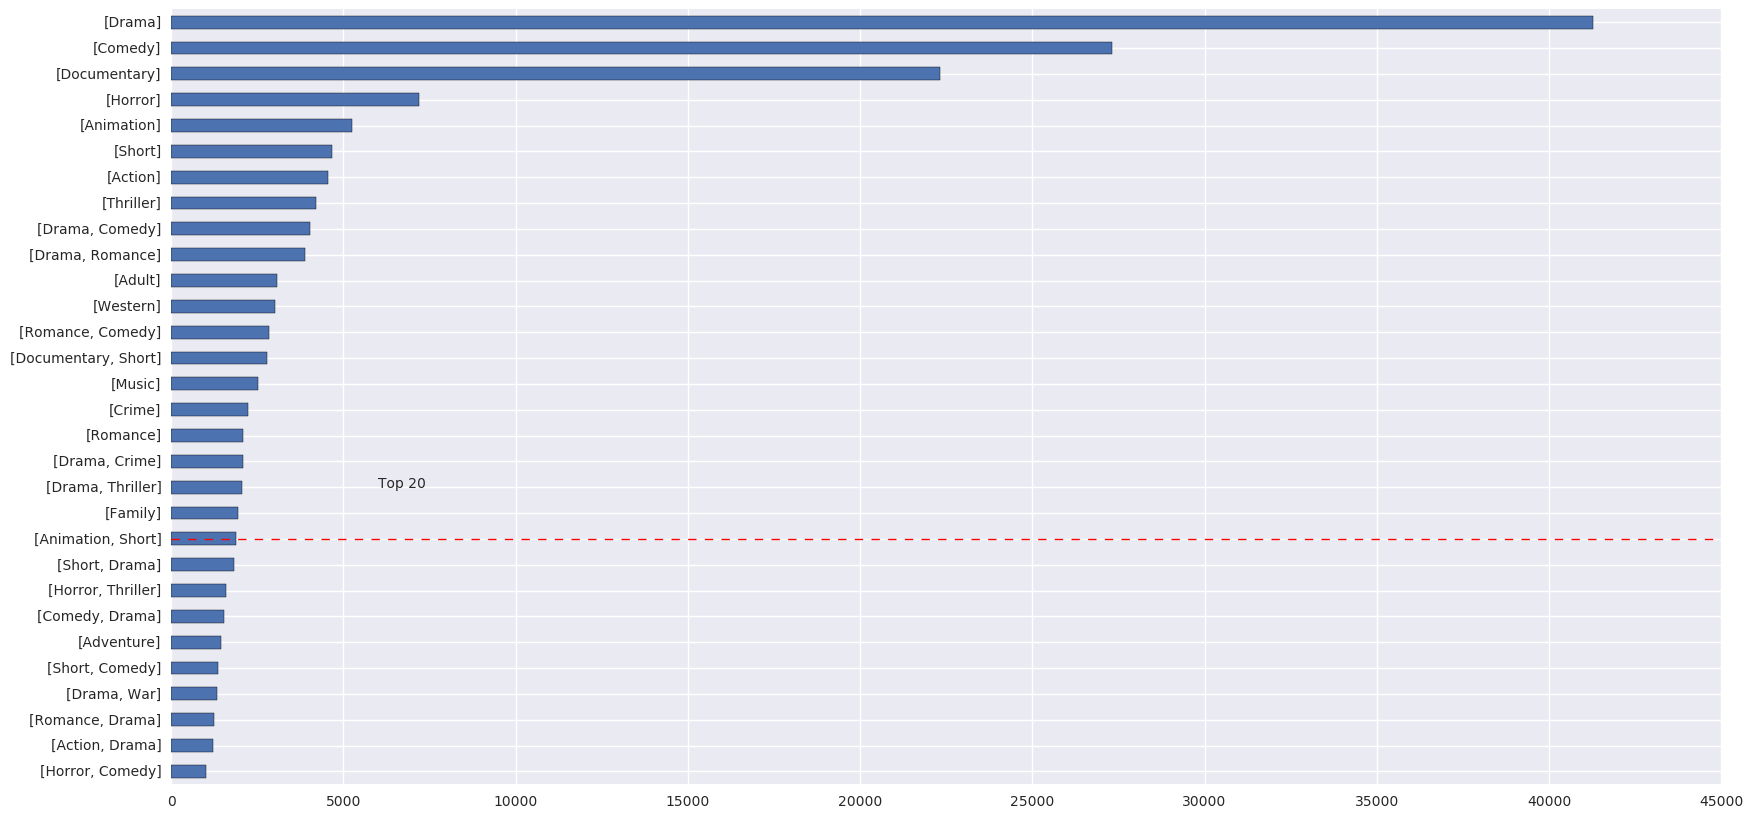

In [41]:
plt.figure(figsize=(20,10))
data['merge_genres'].value_counts()[:30].plot(kind = "barh")
plt.gca().invert_yaxis()
plt.axhline(y = 20, linestyle = "--", color = "r", linewidth = 1)
plt.annotate("Top 20", xy = (6000, 18))

### IV. Which features do you choose for X and why? 

The X includes following features:

Movie ID, movie title, release date, year, popularity, votes (IMDb), vote average (TMDb), vote count, revenue, budget, runtime, spoken languages, status, episode, video, bottom 100 rank, cast, certificates, color info, countries, director, distributors, writer, adult, original language, overview, production companies, production countries, tagline, animation department headcount, art department headcount, art direction headcount, assistant director headcount, camera and electrical department headcount, cast headcount, casting department headcount, casting director headcount, cinematographer headcount, costume department headcount, costume designer headcount, creator headcount, director headcount, distributors headcount, editor headcount, editorial department headcount, electrical department headcount, transportation department headcount, visual effects count, writer headcount, title length, overview length, production company number, production country number, spoken languages choice, tagline length, and total crew headcount.

We retain almost all the features from IMDb and TMDb. There are three things to mention:

1) We decide to **count the number of crew** instead to using their names. For example, under the "electrical department"  feature, we may have 20 people names, then we use "20" as our new feature. The reason is that we think, e.g., action movies will need more people to support in the back, while documentary movies may require less amount of labors. 

2) We also count the title **lengths**, overview lengths... and anything that deals with pure texts.

3) We also consider the **release date**. In fact, we create a new feature as "Month". We think during summertime and holidays, there will be more big movies showcases!

4) We are still trying to** collect information** about the first several actors, the main directors and writers which we think may contribute of the genre of a movie.

We believe these attributes convey the information that are useful for classifying movies by genres. 

### V. How do you sample your data, how many samples, and why? 

For the metadata, we have downloaded all the data from IMDb and TMDb, and we will apply our models and methods on the entire dataset. 

For the posters, due to the limited storage, we plan to randomly select 300 posters from each decade. Thus, in total we will have around 50,000 images to play with, which is really doable for the deeplearning model. 

We want make sure that we cover movies across time and reflect the overall difference between genres.
